In [12]:
import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

In [33]:
path = 'test3.jpg'

In [34]:
x, img = gcv.data.transforms.presets.ssd.load_test(path, short=512)

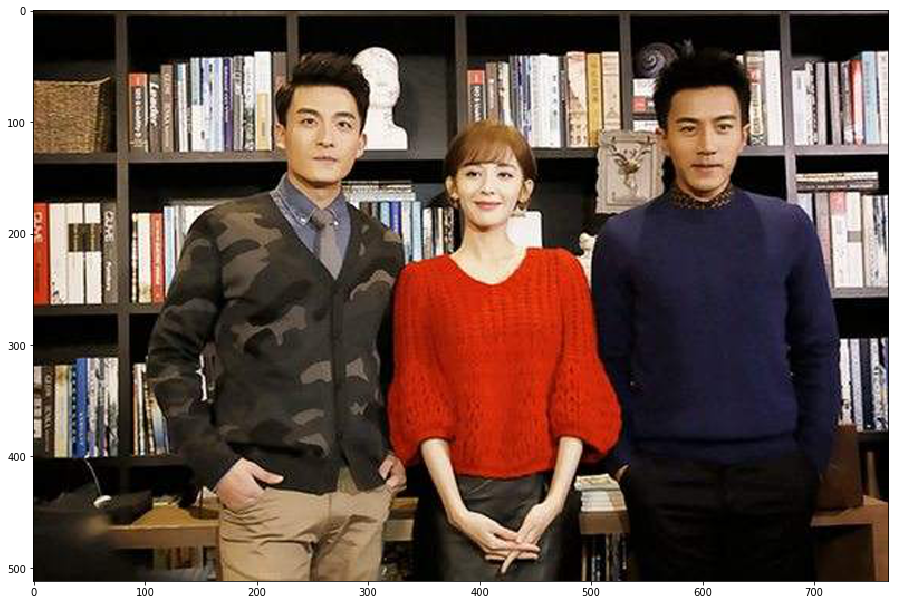

In [35]:
viz.plot_image(img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [36]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 512
SIZE = (224, 224)
MEAN_IMAGE= mx.nd.array([0.485, 0.456, 0.406])
STD_IMAGE = mx.nd.array([0.229, 0.224, 0.225])

In [37]:
def transform(image, label):
    resized = mx.image.resize_short(image, SIZE[0]).astype('float32')
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    cropped /= 255.
    normalized = mx.image.color_normalize(cropped,
                                      mean=MEAN_IMAGE,
                                      std=STD_IMAGE) 
    transposed = nd.transpose(normalized, (2,0,1))
    return transposed, label

In [38]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) else mx.cpu()

In [39]:
%time
ssdnet =  get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

Wall time: 0 ns


In [40]:
%%time
classes, scores, bbox = ssdnet(x.as_in_context(ctx))

Wall time: 26.9 ms


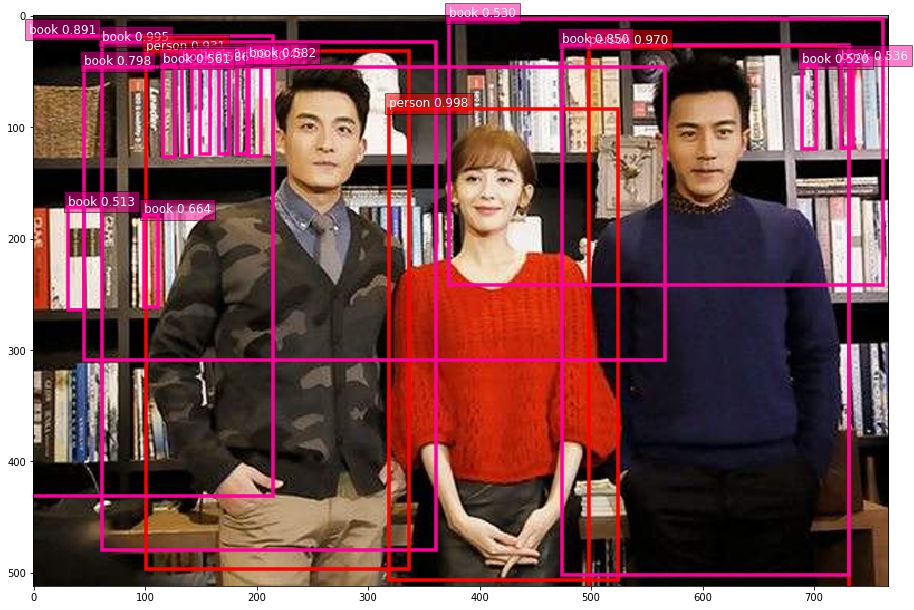

In [41]:
viz.plot_bbox(img, bbox[0], scores[0], classes[0], class_names=ssdnet.classes)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [45]:
bbout = None
for i, (c, s, bb) in enumerate(zip(classes[0].asnumpy(), scores[0].asnumpy(), bbox[0].asnumpy())):
    if c == 0 and s > 0.5:
        bbout = bb
        break
assert bbout is not None

In [46]:
diff_x = int(max((bbout[3]-bbout[1])-(bbout[2]-bbout[0]), 0)/2)
diff_y = int(max(-(bbout[3]-bbout[1])+(bbout[2]-bbout[0]), 0)/2)
x0 = max(int(bbout[0])-diff_x, 0)
x1 = min(int(bbout[2])+diff_x, img.shape[1])
y0 = max(int(bbout[1])-diff_y, 0)
y1 = min(int(bbout[3])+diff_y, img.shape[0])
cropped_img = img[y0:y1, x0:x1, :]

In [47]:
cropped_img = img[y0:y1, x0:x1, :]

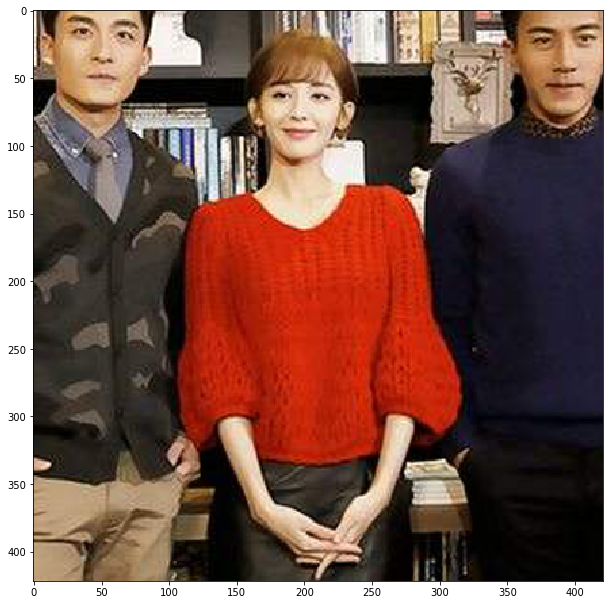

In [48]:
viz.plot_image(cropped_img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [49]:
pspnet = get_model('FCN_resnet50_ade', pretrained=True, ctx=ctx)

In [50]:
from PIL import Image
im = Image.fromarray(cropped_img)
im.save("test.jpg")
x, cropped_loaded = gcv.data.transforms.presets.ssd.load_test('test.jpg', min(cropped_img.shape[1], cropped_img.shape[0]))

In [51]:
output = pspnet.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

In [57]:
%%time
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

Wall time: 1.99 ms


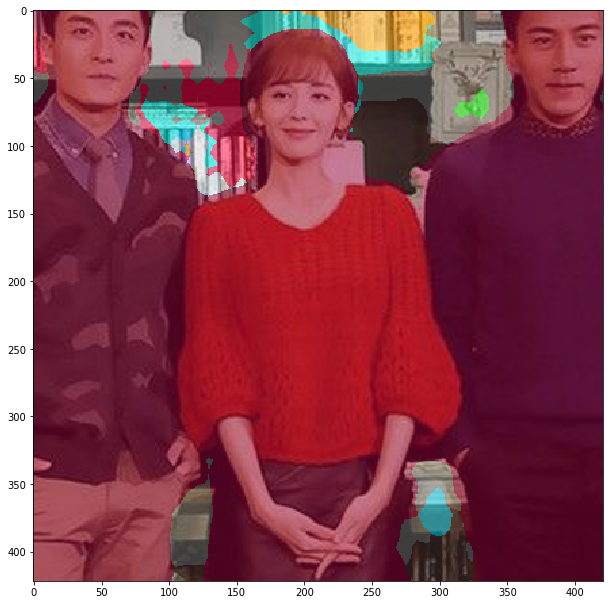

Wall time: 298 ms


In [55]:


combined = (mask+cropped_img)/2

plt.imshow(combined.astype(np.uint8))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [53]:
HUMAN = 12
filtered = (pred == HUMAN)
filtered = filtered.reshape(*filtered.shape, 1).repeat(3, 2)
filtered_img = filtered*cropped_img
filtered_img[filtered==False] = 255

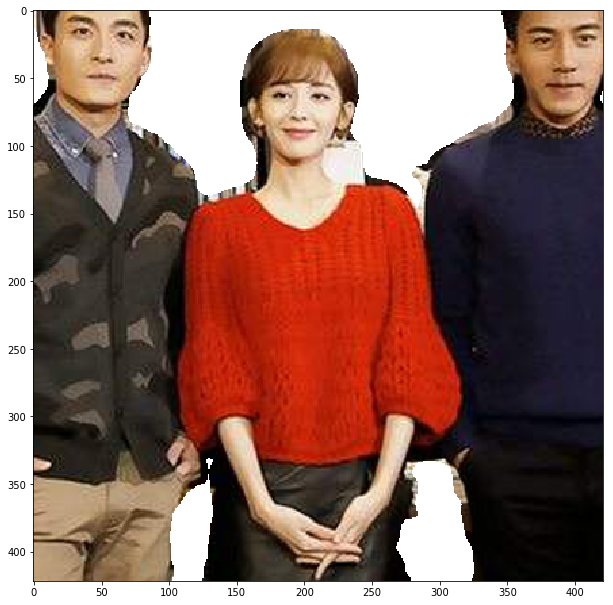

In [54]:
viz.plot_image(filtered_img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()